In [36]:
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from PIL import Image, ImageChops,ImageEnhance

In [37]:
Au_folder_path = "/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au" # authentic image folder
Tp_folder_path = "/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp" # tampered image folder
Au_image_files = [f for f in os.listdir(Au_folder_path) if f.endswith(('.jpg', '.jpeg', '.png','.bmp','.tif'))]
Tp_image_files = [f for f in os.listdir(Tp_folder_path) if f.endswith(('.jpg', '.jpeg', '.png','.bmp','.tif'))]

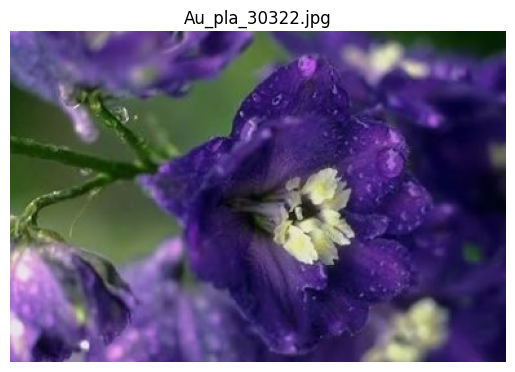

In [38]:
for i in range(1):
    # Construct the full path to the image
    image_path = os.path.join(Au_folder_path, Au_image_files[i])

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.title(Au_image_files[i])  # Show the filename as the title
    plt.axis('off')
    plt.show()

In [39]:
len(Au_image_files),len(Tp_image_files)

(7491, 5123)

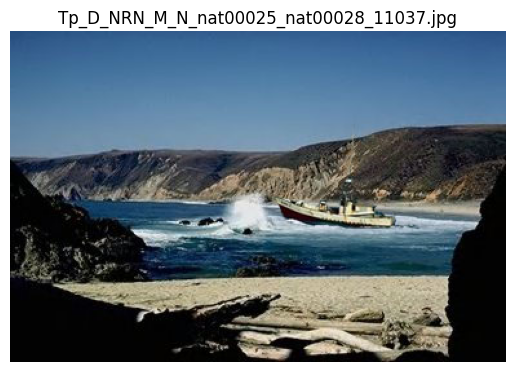

In [40]:
for i in range(1):
    # Construct the full path to the image
    image_path = os.path.join(Tp_folder_path, Tp_image_files[i])

    # Load the image
    image = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

     # Display the image
    plt.imshow(image_rgb)
    plt.title(Tp_image_files[i])  # Show the filename as the title
    plt.axis('off')
    plt.show()

In [41]:

def compute_ela(path, quality=100):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png' 
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    ela_image = ImageChops.difference(image, temp_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff 
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)  
    return ela_image


In [42]:
image_size=(128,128)

In [43]:
def preprocessing(image_path):
    return np.array(compute_ela(image_path).resize(image_size))/255

In [44]:
a=preprocessing("/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/Tp_D_CND_M_N_ani00018_sec00096_00138.tif")

In [45]:
a.shape

(128, 128, 3)

In [46]:
X=[]
Y=[]

In [47]:
import random
path = Au_folder_path
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith(('.jpg', '.jpeg', '.png','.bmp','.tif')):
            full_path = os.path.join(dirname, filename)
            X.append(preprocessing(full_path))
            Y.append(1)
random.shuffle(X)
X = X[:5000]
Y = Y[:5000]
print(len(X), len(Y))

5000 5000


In [48]:
path = Tp_folder_path
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith(('.jpg', '.jpeg', '.png','.bmp','.tif')):
            full_path = os.path.join(dirname, filename)
            X.append(preprocessing(full_path))
            Y.append(0)
print(len(X), len(Y))

10123 10123


In [49]:
from tensorflow.keras.utils import to_categorical
X = np.array(X)
Y = np.array(Y)
X = X.reshape(-1, 128, 128, 3)

In [50]:
X.shape,Y.shape

((10123, 128, 128, 3), (10123,))

In [51]:
X_train,X_val,Y_train,Y_val=train_test_split(X,Y,test_size=0.2,random_state=10)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

8098 8098
2025 2025


In [52]:
X.shape

(497565696, 1, 1, 1)

In [53]:
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [54]:
conv_base = VGG16(
weights='imagenet',
include_top = False,
input_shape = (128,128,3))

In [55]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in conv_base.layers:
    print(layer.name,layer.trainable)
    

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [56]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [57]:
# without transfer learning

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix
# from keras.models import Sequential
# from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
# from tensorflow.keras.optimizers import Adam
# from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import EarlyStopping
# def CNN():
#     model = Sequential()
#     model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', input_shape=(128,128,3)))
#     model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(Flatten())
#     model.add(Dense(units=128, activation='relu'))
#     model.add(Dropout(0.3))
#     model.add(BatchNormalization())
#     model.add(Dense(units=64, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(BatchNormalization())
#     model.add(Dense(units=1, activation='sigmoid'))

#     return model
  

In [58]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(128,activation='relu'))
#model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(1,activation='sigmoid'))

In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15764033 (60.14 MB)
Trainable params: 14028289 (53.51 MB)
Non-trainable params: 1735744 (6.62 MB)
________

In [60]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [61]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.9, 
                                            min_lr=0.00001)

In [62]:
datagen = ImageDataGenerator(
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(X_train)

In [63]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

epochs = 60
batch_size = 32
init_lr = 1e-3

# Define a learning rate schedule using ExponentialDecay
lr_schedule = ExponentialDecay(
    initial_learning_rate=init_lr,
    decay_steps=epochs,
    decay_rate=0.9,
    staircase=True
)

# Use the learning rate schedule in the Adam optimizer
optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [64]:
# Fit the model
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = 60, validation_data = (X_val,Y_val),
                               steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction,earlystopping])

Epoch 1/60
253/253 [==============================] - 40s 141ms/step - loss: 0.4178 - accuracy: 0.8257 - val_loss: 0.6424 - val_accuracy: 0.6326 - lr: 6.5610e-04
Epoch 2/60
253/253 [==============================] - 35s 137ms/step - loss: 0.3439 - accuracy: 0.8676 - val_loss: 1.1039 - val_accuracy: 0.5768 - lr: 4.3047e-04
Epoch 3/60
253/253 [==============================] - 35s 137ms/step - loss: 0.3280 - accuracy: 0.8757 - val_loss: 0.9924 - val_accuracy: 0.5802 - lr: 2.8243e-04
Epoch 4/60
253/253 [==============================] - 35s 137ms/step - loss: 0.3104 - accuracy: 0.8780 - val_loss: 0.2580 - val_accuracy: 0.8993 - lr: 1.8530e-04
Epoch 5/60
253/253 [==============================] - 35s 137ms/step - loss: 0.3041 - accuracy: 0.8848 - val_loss: 0.7518 - val_accuracy: 0.6677 - lr: 1.0942e-04
Epoch 6/60
253/253 [==============================] - 35s 137ms/step - loss: 0.2897 - accuracy: 0.8892 - val_loss: 0.3549 - val_accuracy: 0.8538 - lr: 7.1790e-05
Epoch 7/60
253/253 [========

In [65]:
loss,accuracy=model.evaluate(X_val, Y_val)

64/64 [==============================] - 3s 42ms/step - loss: 0.2580 - accuracy: 0.8993


In [66]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


/tmp/ipykernel_26/3013067133.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1) #horizontal,vertical,position


64/64 [==============================] - 3s 41ms/step


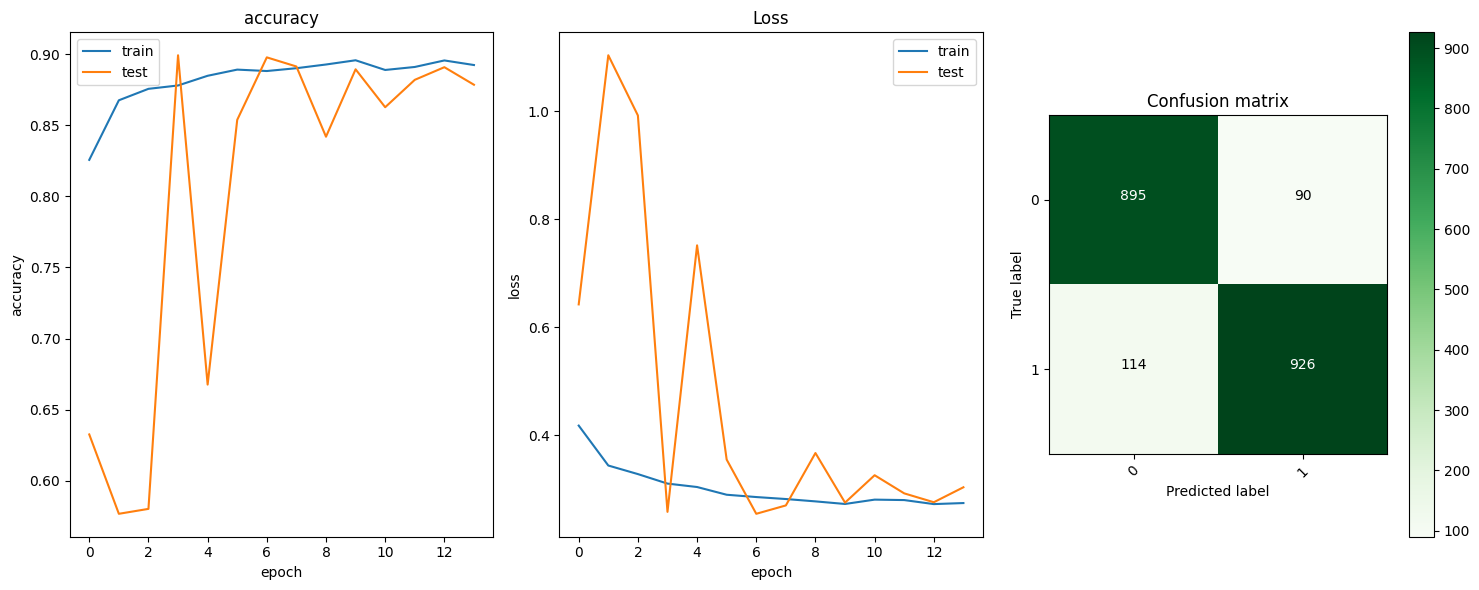

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

plt.subplots(figsize=(15, 6))
plt.subplot(1,3,1) #horizontal,vertical,position
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.subplot(1,3,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'])
plt.subplot(1,3,3)
Y_pred = model.predict(X_val)
Y_pred_classes = np.round(Y_pred) 
Y_true = np.round(Y_val) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(2))
plt.show()

In [68]:
class_names = ['Forged', 'Authentic']

1/1 [==============================] - 0s 22ms/step
Prediction: Forged
Confidence:  94.08%
--------------------------------------------------------------------------------------------------------------


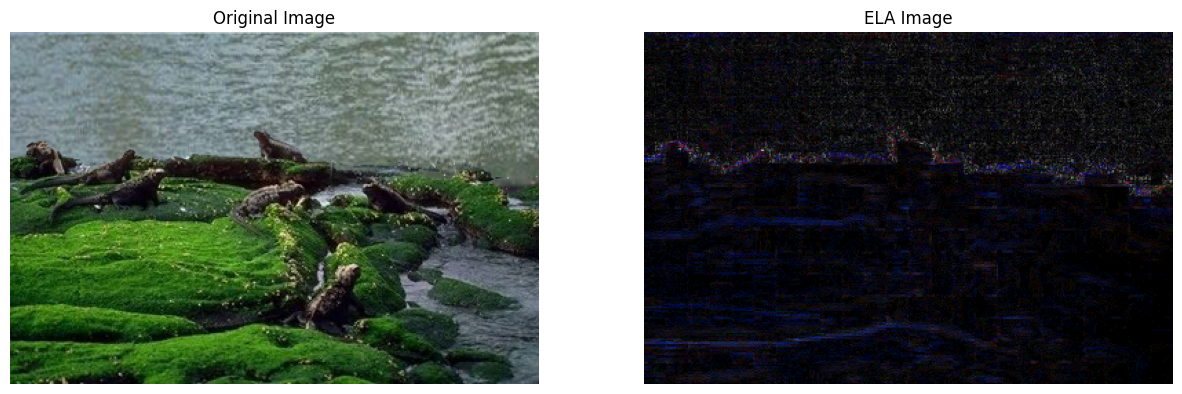

In [69]:
test_image_path = "/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp/Tp_D_CND_M_N_ani00018_sec00096_00138.tif"    # test image path
test_image = preprocessing(test_image_path)
test_image = test_image.reshape(-1, 128, 128, 3)

y_pred = model.predict(test_image)
y_pred_class = round(y_pred[0][0])

fig, ax = plt.subplots(1,2,figsize=(15,5)) 

#display original image
original_image = plt.imread(test_image_path) 
ax[0].axis('off')
ax[0].imshow(original_image)
ax[0].set_title('Original Image')

#display ELA applied image
ax[1].axis('off')
ax[1].imshow(compute_ela(test_image_path,90)) 
ax[1].set_title('ELA Image')

print(f'Prediction: {class_names[y_pred_class]}')
if y_pred<=0.5:
    print(f'Confidence:  {(1-(y_pred[0][0])) * 100:0.2f}%')
else:
    print(f'Confidence: {(y_pred[0][0]) * 100:0.2f}%')
print('--------------------------------------------------------------------------------------------------------------')

1/1 [==============================] - 0s 24ms/step
Prediction: Authentic
Confidence: 99.82%
--------------------------------------------------------------------------------------------------------------


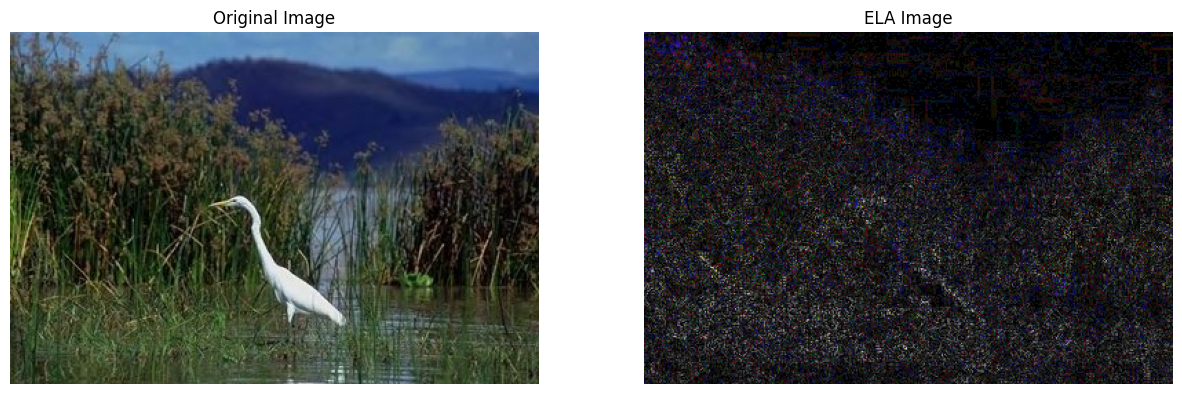

In [70]:
test_image_path = "/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au/Au_ani_00002.jpg"    # test image path
test_image = preprocessing(test_image_path)
test_image = test_image.reshape(-1, 128, 128, 3)

y_pred = model.predict(test_image)
y_pred_class = round(y_pred[0][0])

fig, ax = plt.subplots(1,2,figsize=(15,5)) 

#display original image
original_image = plt.imread(test_image_path) 
ax[0].axis('off')
ax[0].imshow(original_image)
ax[0].set_title('Original Image')

#display ELA applied image
ax[1].axis('off')
ax[1].imshow(compute_ela(test_image_path,90)) 
ax[1].set_title('ELA Image')

print(f'Prediction: {class_names[y_pred_class]}')
if y_pred<=0.5:
    print(f'Confidence:  {(1-(y_pred[0][0])) * 100:0.2f}%')
else:
    print(f'Confidence: {(y_pred[0][0]) * 100:0.2f}%')
print('--------------------------------------------------------------------------------------------------------------')